In [6]:
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

# read data

In [7]:
words = open('../data/names.txt', 'r').read().splitlines()

In [8]:
len(words)

32033

In [9]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [10]:
chars = sorted(list(set(''.join(words))))

# util

In [11]:
itos = {}
itos[0] = '.'
itos |= {i+1: s for i, s in enumerate(chars)}

In [12]:
stoi = {s: i for i, s in itos.items()}

In [71]:
vocab_size = len(stoi)
vocab_size

27

# Build a neural language model

## prepare data

In [13]:
block_size = 3
def build_dataset(data):
    X, Y = [], []
    for w in data[:]:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            # print(''.join([itos[i] for i in context]), '--->', itos[ix])
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]        

    X = torch.tensor(X)
    Y = torch.tensor(Y)        
    print(X.shape, Y.shape)
    return X, Y

In [26]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
         
Xtr, Ytr = build_dataset(words[:n1])
Xdv, Ydv = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])                               

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


# indexing and embeding

In [36]:
C = torch.randn(len(itos), 2)
C[:5]

tensor([[ 0.5596,  0.9473],
        [-0.3376, -1.7946],
        [ 1.2709,  1.2079],
        [ 0.6364,  0.0592],
        [ 0.9746, -0.0174]])

In [37]:
tmp = torch.tensor([[2, 3,3],
                   [1,0,0]])

In [38]:
C[2]

tensor([1.2709, 1.2079])

In [39]:
C[tmp][0,0]

tensor([1.2709, 1.2079])

# torch.cat vs torch.view

In [53]:
emb = C[Xtr][:4]

In [54]:
emb.shape

torch.Size([4, 3, 2])

In [55]:
emb

tensor([[[ 0.5596,  0.9473],
         [ 0.5596,  0.9473],
         [ 0.5596,  0.9473]],

        [[ 0.5596,  0.9473],
         [ 0.5596,  0.9473],
         [ 1.6763, -1.7790]],

        [[ 0.5596,  0.9473],
         [ 1.6763, -1.7790],
         [-0.3376, -1.7946]],

        [[ 1.6763, -1.7790],
         [-0.3376, -1.7946],
         [-0.6984,  1.5742]]])

In [63]:
emb[:,0,:]

tensor([[ 0.5596,  0.9473],
        [ 0.5596,  0.9473],
        [ 0.5596,  0.9473],
        [ 1.6763, -1.7790]])

In [62]:
emb[:,:,0]

tensor([[ 0.5596,  0.5596,  0.5596],
        [ 0.5596,  0.5596,  1.6763],
        [ 0.5596,  1.6763, -0.3376],
        [ 1.6763, -0.3376, -0.6984]])

In [56]:
torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]],1)

tensor([[ 0.5596,  0.9473,  0.5596,  0.9473,  0.5596,  0.9473],
        [ 0.5596,  0.9473,  0.5596,  0.9473,  1.6763, -1.7790],
        [ 0.5596,  0.9473,  1.6763, -1.7790, -0.3376, -1.7946],
        [ 1.6763, -1.7790, -0.3376, -1.7946, -0.6984,  1.5742]])

In [64]:
emb2 = emb.swapaxes(1,2)

In [66]:
torch.cat([emb2[:,:,0], emb2[:,:,1], emb2[:,:,2]],1)

tensor([[ 0.5596,  0.9473,  0.5596,  0.9473,  0.5596,  0.9473],
        [ 0.5596,  0.9473,  0.5596,  0.9473,  1.6763, -1.7790],
        [ 0.5596,  0.9473,  1.6763, -1.7790, -0.3376, -1.7946],
        [ 1.6763, -1.7790, -0.3376, -1.7946, -0.6984,  1.5742]])

In [59]:
emb.view(-1, 6)

tensor([[ 0.5596,  0.9473,  0.5596,  0.9473,  0.5596,  0.9473],
        [ 0.5596,  0.9473,  0.5596,  0.9473,  1.6763, -1.7790],
        [ 0.5596,  0.9473,  1.6763, -1.7790, -0.3376, -1.7946],
        [ 1.6763, -1.7790, -0.3376, -1.7946, -0.6984,  1.5742]])

In [60]:
(torch.cat(torch.unbind(emb, 1),1) == emb.view(-1, 6)).all()

tensor(True)

In [70]:
(torch.cat(torch.unbind(emb2, 2),1) == emb.view(-1, 6)).all()

tensor(True)

In [68]:
(torch.cat(torch.unbind(emb, 2),1) == emb.view(-1, 6)).all()

tensor(False)

In [50]:
(torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]],1) == emb.view(-1, 6)).all()

tensor(True)

In [51]:
(torch.cat([emb[:,:,0], emb[:,:,1]],1) == emb.view(-1, 6)).all()

tensor(False)

In [67]:
(torch.cat([emb2[:,:,0], emb2[:,:,1], emb2[:,:,2]],1) == emb.view(-1, 6)).all()

tensor(True)

In [52]:
torch.cat([emb[:,:,0], emb[:,:,1]],1).shape

torch.Size([182437, 6])

# figuring out learning rate

In [156]:
EMBD_DIM = 10
HIDDEN_DIM = 200

In [157]:
C = torch.randn(len(itos), EMBD_DIM)
w1 = torch.randn(EMBD_DIM*block_size, HIDDEN_DIM)
b1 = torch.randn(HIDDEN_DIM)
w2 = torch.randn(HIDDEN_DIM, vocab_size) * 0.02
b2 = torch.randn(vocab_size) * 0.01
parameters = [C, w1, b1, w2, b2]

In [158]:
for p in parameters:
    p.requires_grad = True

In [159]:
loglossi = []
lossi = []

In [160]:
lre = torch.linspace(-3, 0, 1000)
lri = 10**lre

In [161]:
#STEPS = 800_000
STEPS = 1_000
for i in tqdm(range(STEPS)):
    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    # forward
    emb = C[Xb] # (32, 3, 2)
    h = (emb.view(emb.shape[0], -1) @ w1 + b1).tanh() # (32, 100)
    logits = h @ w2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)

    # backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    # lr = 0.1 if i < STEPS//2 else 0.01
    lr = lri[i]
    for p in parameters:
        p.data += -lr * p.grad
        
    # tracking
    loglossi.append(loss.log10().item())
    lossi.append(loss.item())

100%|████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3037.02it/s]


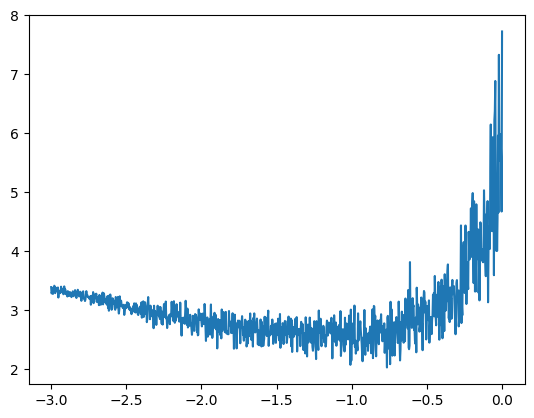

In [162]:
plt.plot(lre, lossi);

# Train a neural language model

In [163]:
EMBD_DIM = 10
HIDDEN_DIM = 200

In [164]:
C = torch.randn(len(itos), EMBD_DIM)
w1 = torch.randn(EMBD_DIM*block_size, HIDDEN_DIM)
b1 = torch.randn(HIDDEN_DIM)
w2 = torch.randn(HIDDEN_DIM, vocab_size) * 0.02
b2 = torch.randn(vocab_size) * 0.01
parameters = [C, w1, b1, w2, b2]

In [165]:
sum(p.nelement() for p in parameters)

11897

In [166]:
for p in parameters:
    p.requires_grad = True

In [167]:
loglossi = []
lossi = []

In [ ]:
# STEPS = 800_000
STEPS = 200_000
# STEPS = 10_000
for i in tqdm(range(STEPS)):
    # mini-batch
    ix = torch.randint(0, Xtr.shape[0], (32,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    # forward
    emb = C[Xb] # (32, 3, 2)
    h = (emb.view(emb.shape[0], -1) @ w1 + b1).tanh() # (32, 100)
    logits = h @ w2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)

    # backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < STEPS//2 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # tracking
    loglossi.append(loss.log10().item())
    lossi.append(loss.item())

  3%|█▉                                                        | 6819/200000 [00:02<01:06, 2906.52it/s]

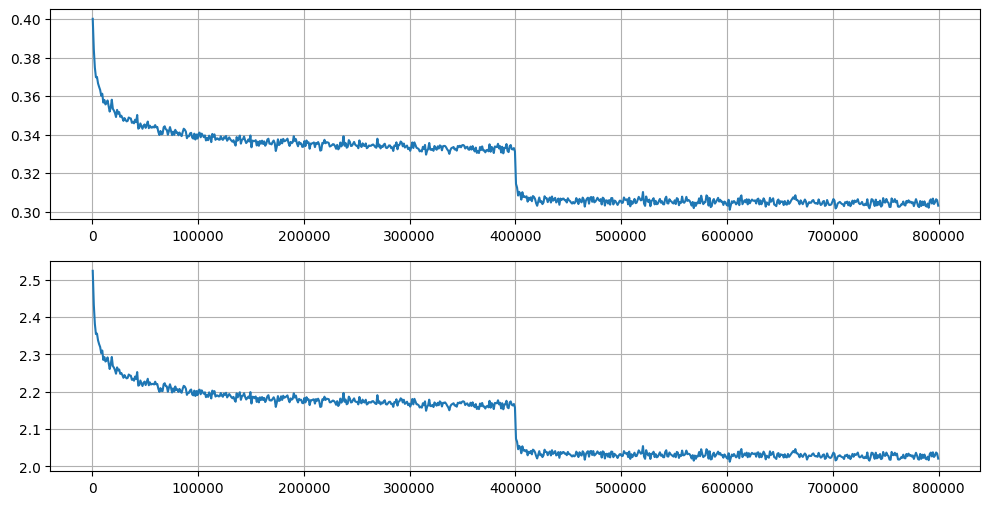

In [145]:
group_size = 1_000
plt.figure(figsize=(12,6))
plt.subplot(211)
plt.plot(
    torch.arange(len(loglossi)).view(-1, group_size).float().mean(1),
    torch.tensor(loglossi).view(-1, group_size).mean(1)
)
plt.grid()
plt.subplot(212)
plt.plot(
    torch.arange(len(lossi)).view(-1, group_size).float().mean(1),
    torch.tensor(lossi).view(-1, group_size).mean(1)
)
plt.grid()
plt.show()

## compute loss on train/dev/test

In [131]:
def eval_dataset(X, Y):
    with torch.no_grad():
        emb = C[X] # (32, 3, 2)
        h = (emb.view(emb.shape[0], -1) @ w1 + b1).tanh() # (32, 100)
        logits = h @ w2 + b2 # (32, 27)
        loss = F.cross_entropy(logits, Y)
        print(loss.item())

In [132]:
eval_dataset(Xtr, Ytr)
eval_dataset(Xdv, Ydv)
# eval_dataset(Xte, Yte)

2.030031204223633
2.141448497772217


## visualize the embedding

In [133]:
from sklearn.manifold import TSNE

In [140]:
tsne = TSNE(n_components=2, verbose=1, random_state=1235, perplexity=5)
# tsne = TSNE(n_components=2, verbose=1, random_state=123)

In [141]:
z = tsne.fit_transform(C.detach().numpy())

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 27 samples in 0.000s...
[t-SNE] Computed neighbors for 27 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 27 / 27
[t-SNE] Mean sigma: 2.038197
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.448341
[t-SNE] KL divergence after 1000 iterations: 0.547788


In [142]:
C.shape, z.shape

(torch.Size([27, 10]), (27, 2))

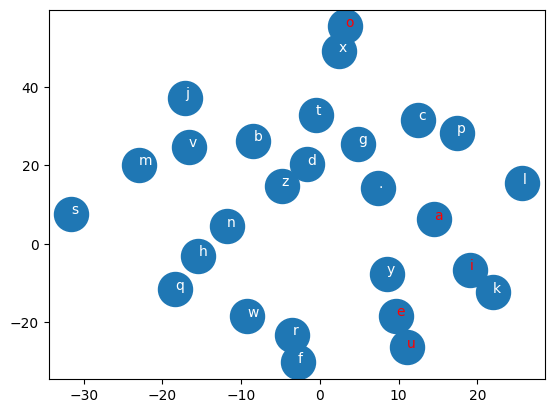

In [143]:
plt.scatter(z[:,0].data, z[:,1].data, s=600)
for i in range(z.shape[0]):
    if itos[i] in 'aeiou':
        c = 'red'
    else:
        c = 'white'
    plt.text(z[i,0].item(), z[i,1].item(), itos[i], color=c)

# generate names

In [138]:
g = torch.Generator().manual_seed(2147483647 + 10)

In [139]:
block_size = 3
for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = (emb.view(1, -1) @ w1 + b1).tanh()
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carmahela.
jharli.
jori.
rehtl.
sklassie.
mahnen.
deliah.
jareen.
nellara.
chaiir.
